In [6]:
# 🧰 Step 1: Install Dependencies
!pip install yfinance deap matplotlib scikit-learn torch --quiet

In [7]:
# 📊 Step 2: Download Financial Data
import yfinance as yf
import pandas as pd

df = yf.download('AAPL', start='2018-01-01', end='2024-12-31')
df = df[['Close']].dropna()
df.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2024-12-23,254.989655
2024-12-24,257.916443
2024-12-26,258.735504
2024-12-27,255.309296
2024-12-30,251.923019


In [8]:
# 🔄 Step 3: Preprocess Data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

import torch
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [9]:
# 🧠 Step 4: CNN-LSTM Model
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, conv_filters=16, lstm_hidden=50, kernel_size=3):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, conv_filters, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))        # [B, conv_filters, seq_len - k + 1]
        x = x.permute(0, 2, 1)               # [B, time_steps, features]
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


In [10]:
#Step 5: GA Optimization
from deap import base, creator, tools, algorithms
import torch
import random
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear DEAP registry if needed
for name in ['FitnessMin', 'Individual']:
    if hasattr(creator, name):
        delattr(creator, name)

# Create types
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Parameter bounds
LR_RANGE = (0.0001, 0.01)
EPOCH_RANGE = (10, 40)
CONV_FILTERS_CHOICES = [8, 16, 32]
LSTM_HIDDEN_CHOICES = [32, 50, 64]

# Define gene generation
toolbox.register("lr", lambda: round(random.uniform(*LR_RANGE), 5))
toolbox.register("epochs", lambda: random.randint(*EPOCH_RANGE))
toolbox.register("conv_filters", lambda: random.choice(CONV_FILTERS_CHOICES))
toolbox.register("lstm_hidden", lambda: random.choice(LSTM_HIDDEN_CHOICES))

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.lr, toolbox.epochs, toolbox.conv_filters, toolbox.lstm_hidden), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def eval_model(individual):
    lr, epochs, conv_filters, lstm_hidden = individual
    model = CNN_LSTM(conv_filters=int(conv_filters), lstm_hidden=int(lstm_hidden)).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    try:
        for _ in range(int(epochs)):
            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output.squeeze(), y_train)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            pred = model(X_test).squeeze()
            val_loss = criterion(pred, y_test).item()

        return (val_loss,)
    except Exception as e:
        print(f"⚠️ Error during evaluation: {e}")
        return (float('inf'),)

toolbox.register("evaluate", eval_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)

def safe_mutate(individual, mu=0, sigma=0.1, indpb=0.4):
    tools.mutGaussian(individual, mu, sigma, indpb)
    individual[0] = round(max(min(individual[0], LR_RANGE[1]), LR_RANGE[0]), 5)
    individual[1] = int(max(min(individual[1], EPOCH_RANGE[1]), EPOCH_RANGE[0]))
    individual[2] = min(CONV_FILTERS_CHOICES, key=lambda x: abs(x - individual[2]))
    individual[3] = min(LSTM_HIDDEN_CHOICES, key=lambda x: abs(x - individual[3]))
    return individual,

toolbox.register("mutate", safe_mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA Loop
POP_SIZE = 10
N_GEN = 5
population = toolbox.population(n=POP_SIZE)

for gen in range(N_GEN):
    print(f"\n⚙️ Generation {gen+1}")
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.3:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid)
    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring
    best = tools.selBest(population, 1)[0]
    print(f"🔍 Best Loss: {best.fitness.values[0]:.5f}, LR: {best[0]:.5f}, Epochs: {int(best[1])}, Conv: {best[2]}, LSTM: {best[3]}")



⚙️ Generation 1


c:\Users\srini\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1360, 1])) that is different to the input size (torch.Size([1360])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\srini\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([340, 1])) that is different to the input size (torch.Size([340])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🔍 Best Loss: 0.13475, LR: 0.00831, Epochs: 17, Conv: 13.65634716705768, LSTM: 49.58247708960749

⚙️ Generation 2
🔍 Best Loss: 0.13264, LR: 0.00831, Epochs: 17, Conv: 13.65634716705768, LSTM: 49.58247708960749

⚙️ Generation 3
🔍 Best Loss: 0.12155, LR: 0.00831, Epochs: 17, Conv: 16, LSTM: 50

⚙️ Generation 4
🔍 Best Loss: 0.12357, LR: 0.00831, Epochs: 17, Conv: 13.65634716705768, LSTM: 49.58247708960749

⚙️ Generation 5
🔍 Best Loss: 0.12357, LR: 0.00831, Epochs: 17, Conv: 13.65634716705768, LSTM: 49.58247708960749


In [11]:
# ✅ Step 6: Train Final Model with Best Params
best_ind = tools.selBest(population, k=1)[0]
best_lr, best_epochs, best_filters, best_hidden = best_ind
print(f"✅ Best Params -> LR: {best_lr:.5f}, Epochs: {int(best_epochs)}, Conv Filters: {int(best_filters)}, LSTM Hidden: {int(best_hidden)}")

model = CNN_LSTM(conv_filters=int(best_filters), lstm_hidden=int(best_hidden))
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
criterion = nn.MSELoss()

for epoch in range(int(best_epochs)):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


✅ Best Params -> LR: 0.00831, Epochs: 17, Conv Filters: 13, LSTM Hidden: 49


c:\Users\srini\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


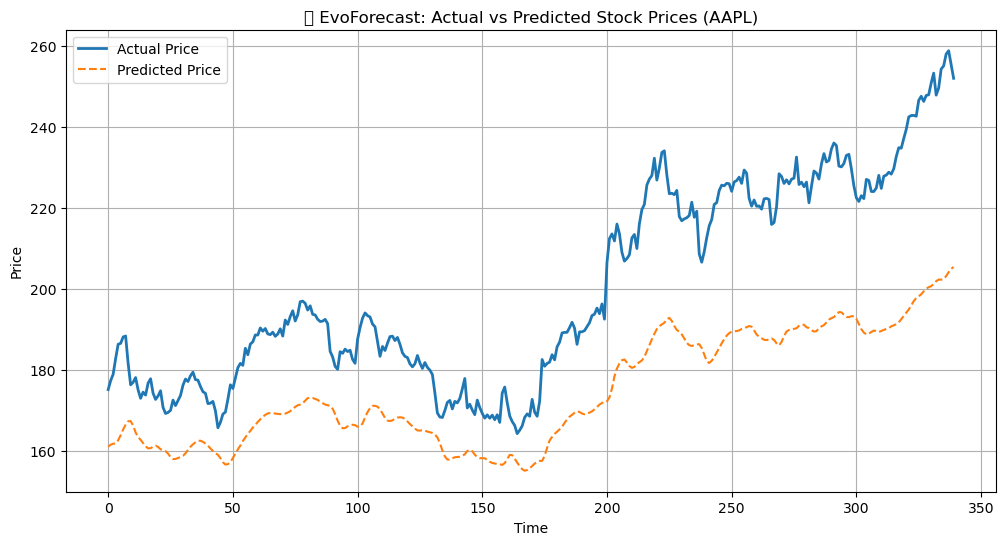

In [12]:
# 📉 Step 7: Predictions
model.eval()
with torch.no_grad():
    pred = model(X_test).squeeze().numpy()
    actual = y_test.squeeze().numpy()

    pred_rescaled = scaler.inverse_transform(pred.reshape(-1, 1))
    actual_rescaled = scaler.inverse_transform(actual.reshape(-1, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_rescaled, label="Actual Price", linewidth=2)
plt.plot(pred_rescaled, label="Predicted Price", linestyle='--')
plt.title("📈 EvoForecast: Actual vs Predicted Stock Prices (AAPL)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# 🔮 Step 8: Predict Next Day
last_seq = torch.tensor(scaled_data[-SEQ_LEN:], dtype=torch.float32).reshape(1, SEQ_LEN, 1).permute(0, 2, 1)
model.eval()
with torch.no_grad():
    next_pred_scaled = model(last_seq).item()
    next_pred_price = scaler.inverse_transform([[next_pred_scaled]])[0][0]

print(f"🔮 Next Predicted Trade Price: ${next_pred_price:.2f}")


🔮 Next Predicted Trade Price: $205.08


In [14]:
# 🧮 Step 9: Accuracy
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actual_rescaled, pred_rescaled)
avg_actual = np.mean(actual_rescaled)
accuracy = 100 - (np.sqrt(mse) / avg_actual * 100)

print(f"📊 MSE: {mse:.4f}")
print(f"✅ Forecast Accuracy: {accuracy:.2f}%")


📊 MSE: 771.0919
✅ Forecast Accuracy: 86.11%


C:\Users\srini\AppData\Local\Temp\ipykernel_18952\519127970.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\srini\AppData\Local\Temp\ipykernel_18952\519127970.py:16: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\srini\AppData\Local\Temp\ipykernel_18952\519127970.py:16: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\srini\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\srini\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\srini\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: 

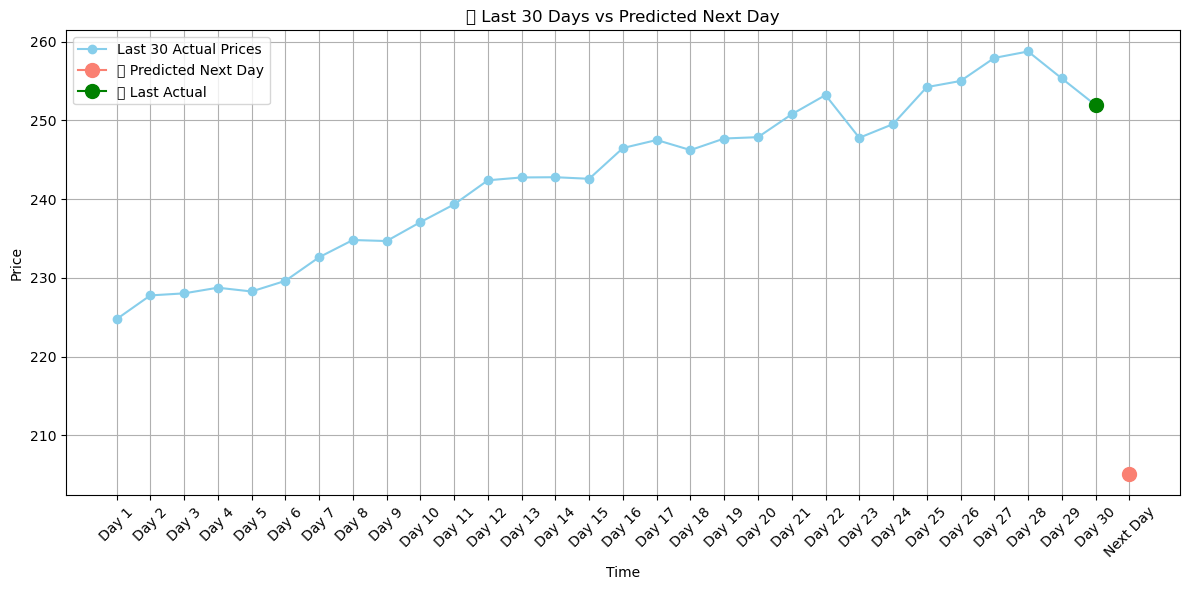

In [15]:
# 📈 Step 10: Last 30 Days + Next Day Prediction
plt.figure(figsize=(12, 6))
days = [f"Day {i+1}" for i in range(30)] + ["Next Day"]
prices = actual_rescaled[-30:].flatten().tolist() + [next_pred_price]

plt.plot(range(30), prices[:-1], marker='o', label="Last 30 Actual Prices", color='skyblue')
plt.plot(30, prices[-1], marker='o', markersize=10, label="🔮 Predicted Next Day", color='salmon')
plt.plot(29, prices[-2], marker='o', markersize=10, label="✅ Last Actual", color='green')

plt.xticks(range(31), days, rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("📈 Last 30 Days vs Predicted Next Day")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\srini\AppData\Local\Temp\ipykernel_18952\610337623.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\srini\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


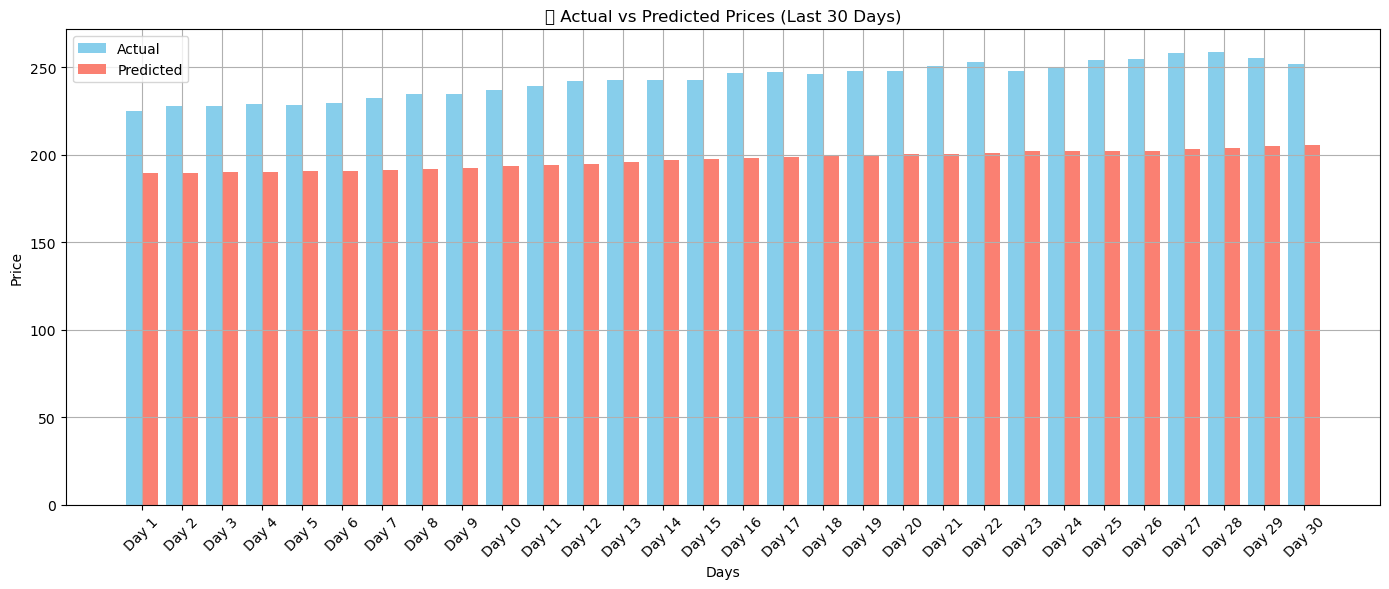

In [16]:
# 📊 Bar Chart: Actual vs Predicted (Last 30 Days)
n = 30
actual_subset = actual_rescaled[-n:].flatten()
predicted_subset = pred_rescaled[-n:].flatten()

indices = np.arange(n)
bar_width = 0.4

plt.figure(figsize=(14, 6))
plt.bar(indices, actual_subset, width=bar_width, label='Actual', color='skyblue')
plt.bar(indices + bar_width, predicted_subset, width=bar_width, label='Predicted', color='salmon')

plt.xlabel("Days")
plt.ylabel("Price")
plt.title("📊 Actual vs Predicted Prices (Last 30 Days)")
plt.xticks(indices + bar_width / 2, [f"Day {i+1}" for i in range(n)], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


🔮 Next Predicted Trade Price: $205.08


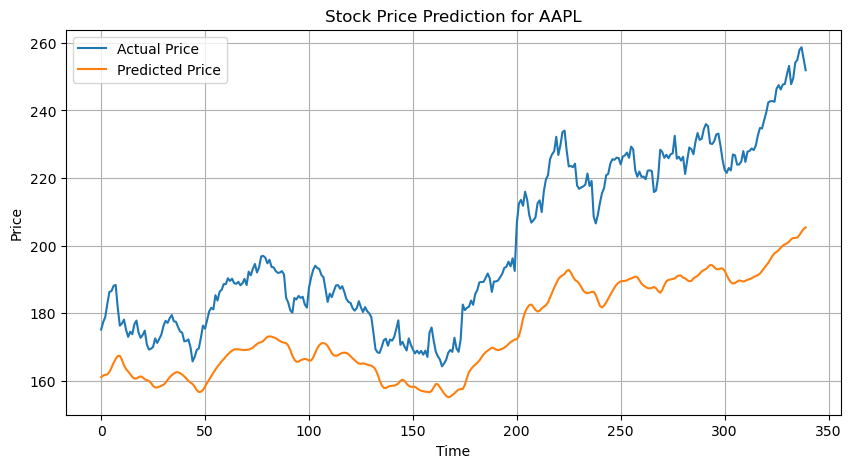

In [ ]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


def predict_stock(ticker):
    global df, scaled_data, X, y  # Make sure these are accessible
    try:
        df = yf.download(ticker, start='2018-01-01', end='2024-12-31')
        df = df[['Close']].dropna()

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['Close']])
        X, y = create_sequences(scaled_data, SEQ_LEN)

    except Exception as e:
        print(f"Error downloading or processing data for {ticker}: {e}")
        result_label.config(text=f"Error: Could not process {ticker}. Check the ticker symbol.")
        return

    # Embed the plot into the Tkinter window
    fig, ax = plt.subplots(figsize=(10, 5))  # Adjust figure size as needed
    ax.plot(actual_rescaled, label="Actual Price")
    ax.plot(pred_rescaled, label="Predicted Price")
    ax.set_title(f"Stock Price Prediction for {ticker}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)


    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    print(f"🔮 Next Predicted Trade Price: ${next_pred_price:.2f}")
    result_label.config(text=f"🔮 Next Predicted Trade Price: ${next_pred_price:.2f}")



def on_predict_button_click():
    selected_ticker = stock_combo.get()
    if selected_ticker:
        for widget in plot_frame.winfo_children():
            widget.destroy() #clear the frame
        result_label.config(text=f"Predicting for {selected_ticker}...")
        predict_stock(selected_ticker)
        result_label.config(text=f"Prediction complete for {selected_ticker}")
    else:
        result_label.config(text="Please select a stock.")

# Create main application window
root = tk.Tk()
root.title("Stock Prediction App")

# Stock selection
stock_label = ttk.Label(root, text="Select Stock:")
stock_label.grid(row=0, column=0, padx=5, pady=5)
stock_combo = ttk.Combobox(root, values=['AAPL', 'MSFT', 'GOOG', 'AMZN'])  # Add more stocks
stock_combo.grid(row=0, column=1, padx=5, pady=5)
stock_combo.current(0)  # Set initial selection

# Predict button
predict_button = ttk.Button(root, text="Predict", command=on_predict_button_click)
predict_button.grid(row=1, column=0, columnspan=2, pady=10)

# Result label
result_label = ttk.Label(root, text="")
result_label.grid(row=2, column=0, columnspan=2, pady=5)

# Frame for the plot
plot_frame = ttk.Frame(root)
plot_frame.grid(row=3, column=0, columnspan=2, pady=10)


root.mainloop()